## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html 

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": 
- https://www.uio.no/english/studies/examinations/cheating/index.html 

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2
If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [559]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [560]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [561]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [562]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [563]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

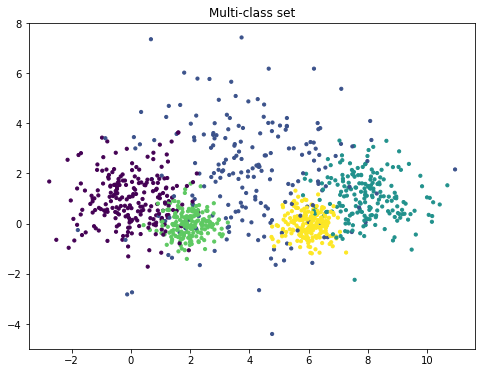

In [564]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

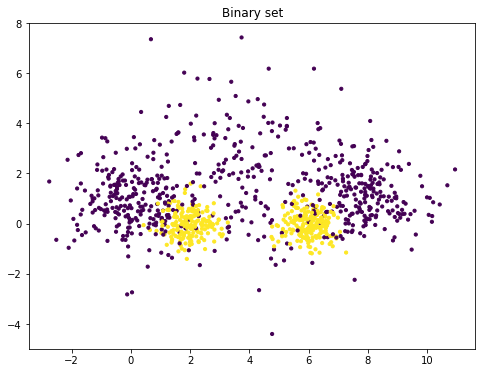

In [565]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [566]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [567]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

In [568]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
        self.loss_per_epoch = [] # List for storing the calculated loss on the training set for each epoch
        self.acc_per_epoch = [] # List for storing the calculated accuracy on the training set for each epoch
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10):
        """X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N,
        the targets values for the training data"""
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, m) = X_train.shape
        self.weights = weights = np.zeros(m)

        for e in range(epochs):
            mse = loss(X_train, t_train, weights) #Calculate the MSE 
            self.loss_per_epoch.append(mse)
            acc = accuracy(self.predict(X_train), t_train) # Calculate the accuarcy 
            self.acc_per_epoch.append(acc)
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)      
        
        print("")
        print("Loss after 1 epoch: {}".format(self.loss_per_epoch[0]))
        print("Loss after {} epochs: {}".format(epochs, self.loss_per_epoch[-1]))
        print("Acc after 1 epoch: {}".format(self.acc_per_epoch[0]))
        print("Acc after {} epochs: {}".format(epochs, self.acc_per_epoch[-1]))

    
    # Plotting the loss and accuracy functions 
    def plot_loss_acc(self):
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
        ax1.plot(self.loss_per_epoch, label="Training Loss")
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(self.acc_per_epoch, color='red', label="Accuracy training")
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')

        plt.show()
      
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        (N, m) = X.shape
        if self.bias and m < 3: # Checking if bias is not already added 
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

# Returns the MSE of the predicted data and the target data
def loss(X, t_train, w):  
    '''
    Page 23, Programming machine learning: from coding to deep learning 
    Perrotta, Paolo (2020)
    '''
    # Predicts the target value for the input data using the weight vector w
    predicted = X @ w
    # Calculates the MSE using the predicted and target data
    mse = np.average((predicted - t_train)**2)
    return mse


# Max-min scaler: returns a training set with scaled features 
def scaling(X_train):
    copy_x = np.copy(X_train)
    # Find the minimum across the whole training data
    minimum = min(min(x) for x in copy_x) 
    # Find the maximum across the whole training data
    maximum = max(max(x) for x in copy_x)  
    
    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[1]):
            # Defining scale with min and max values
            copy_x[i][j] = (X_train[i][j]-minimum)/(maximum-minimum) 
    
    return copy_x

We can train and test a first classifier.

In [569]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [570]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train)
accuracy(cl.predict(X_val), t2_val)


Loss after 1 epoch: 0.386
Loss after 10 epochs: 287.41840035594083
Acc after 1 epoch: 0.614
Acc after 10 epochs: 0.49


0.522

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [571]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

    plt.show()

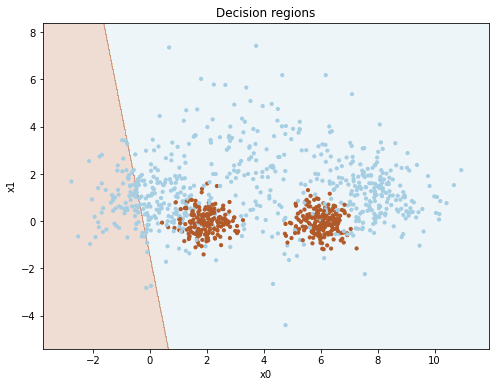

In [572]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.

____________________________________________________________________________________________________________________
**Answer:**
When tuning the *epochs* hyperparamter, turning it up generally gave better results, but with deminishing returns. That is probably because of the dataset having a large degree of overlap between the two classes.

When tuning the *eta* hyperparamter, large values don't give good results. Ideally a smaller value around 0.01 seems to give the best accuracy. 

I found consistently good results using eta = 0.01 and epochs = 1200. This generated accuracy values around 0.745.

In addition I experienced overflow when having a large value for epoch. Some values may have become too large for the dataset to handle. 
____________________________________________________________________________________________________________________


Loss after 1 epoch: 0.386
Loss after 1200 epochs: 0.18089702770049873
Acc after 1 epoch: 0.614
Acc after 1200 epochs: 0.753


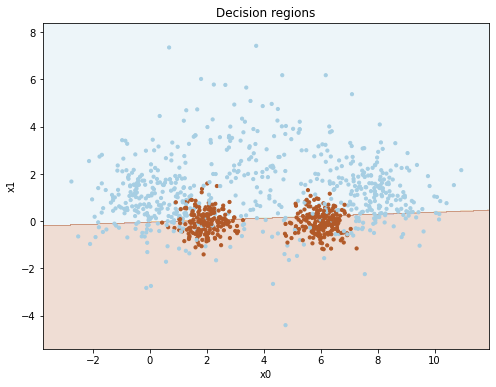

In [573]:
# Tuned parameters
cl_tuned = NumpyLinRegClass()
cl_tuned.fit(X_train, t2_train, eta = 0.01, epochs=1200)
plot_decision_regions(X_train, t2_train, cl_tuned)

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

____________________________________________________________________________________________________________________
**Answer:** The function is as expected. In the graph for calculated loss per epoch, the loss is slowly decresing per epoch. This is because for each epoch we find a better decision boundary. 

The function for accuracy is less monotone. This graph is more fluctuating, but shows a trend where the accuracy increases after a number of epochs. 
____________________________________________________________________________________________________________________

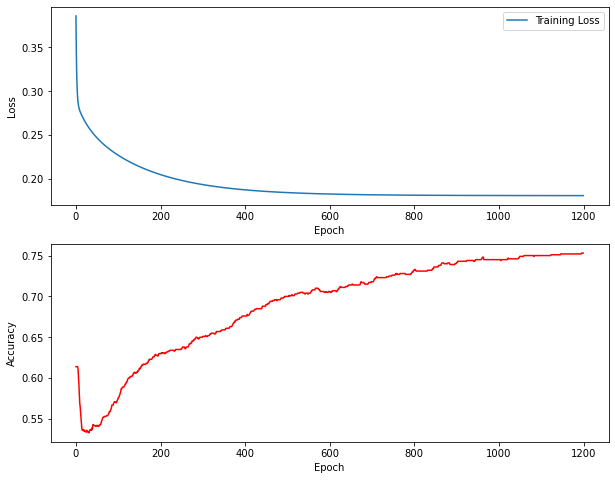

Accuracy validation set: 0.696
Accuracy training set: 0.753


In [574]:
# Plotting accuracy and loss 
cl_tuned.plot_loss_acc()
acc = accuracy(cl_tuned.predict(X_val), t2_val)
acc2 = accuracy(cl_tuned.predict(X_train), t2_train)
print("Accuracy validation set: {}".format(acc))
print("Accuracy training set: {}".format(acc2))

### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

____________________________________________________________________________________________________________________
**Answer:** I implemented the max-min scaler for scaling the training set. After scaling the data I experienced slightly better accuracy and loss when assigning a small value for the *eta* parameter and a larger value for the *epoch* parameter. 

When comparing the results before and after scaling the training set, I observed better performance by tuning up both the epoch and eta hyper-parameters with the scaled data. Also when assigning a value < 10 000 for *epoch* I experienced a flat function for accuracy. 

I found consistently good results using eta = 0.2 and epochs = 10 000. This generated accuracy values around 0.753. After a point there is no improvement when tuning the parameters.
____________________________________________________________________________________________________________________


Loss after 1 epoch: 0.386
Loss after 10000 epochs: 0.18085927539471283
Acc after 1 epoch: 0.614
Acc after 10000 epochs: 0.753


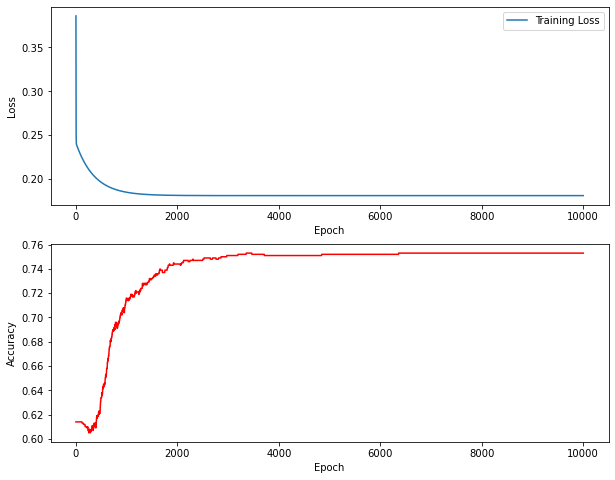

Accuracy training set : 0.753
Accuracy validation set : 0.768


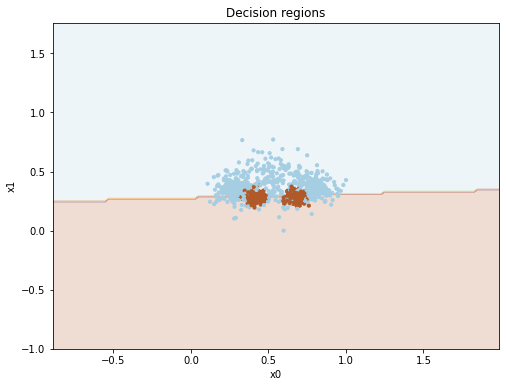

In [575]:

# Training scaled data set
scaled_X = scaling(X_train) # Scaled data
cl_scaled = NumpyLinRegClass()
cl_scaled.fit(scaled_X, t2_train, eta=0.2, epochs=10000)
cl_scaled.plot_loss_acc()
acc = accuracy(cl_scaled.predict(X_val), t2_val)
acc2 = accuracy(cl_scaled.predict(scaled_X), t2_train)
print("Accuracy training set : {}".format(acc2))
print("Accuracy validation set : {}".format(acc))
plot_decision_regions(scaled_X, t2_train, cl_scaled)

## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.


No improvments in loss in 10 epochs after 3954 total epochs. Stopping training.

Loss after 1 epoch = 0.6931471805599454
Loss after 3954 epochs = 0.49951379154918607
Accuracy after 1 epoch = 0.614
Accuracy after 3954 epoch = 0.76


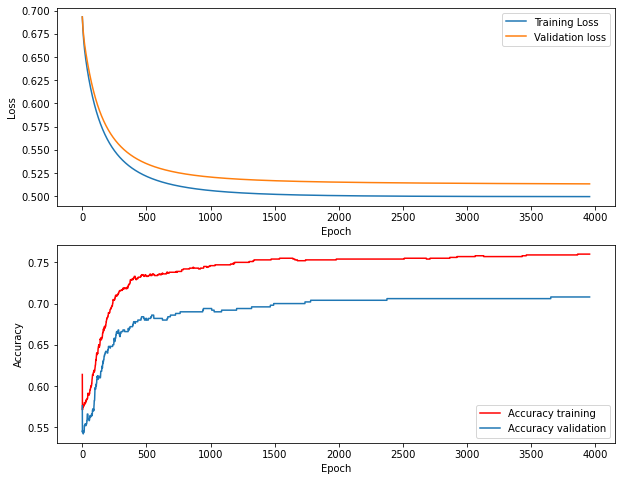

Accuracy validation set: 0.708
Accuracy training set: 0.76


In [576]:
def add_bias_log(X): # Week 7 soultion
    """X is a Nxm matrix: N datapoints, m features
    Return a Nx(m+1) matrix with added bias in position zero"""
    N = X.shape[0]
    bias = np.ones((N,1)) # Make a N*1 matrix of 1-s
    # Concatenate the column of bias in front of the columns of X.
    return np.concatenate((bias, X), axis  = 1) 

# Sigmoid function
def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

class NumpyLogReg(NumpyClassifier):
    
    def __init__(self):
        self.loss_per_epoch = []
        self.acc_per_epoch = []
        self.loss_per_epoch_val = []
        self.acc_per_epoch_val = []
        self.epochs_count = 0

    def fit(self, X_train, t_train, tol, eta = 0.1, epochs=1000, n_epochs_no_update=5, X_val=None, t_val=None):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        (N, m) = X_train.shape
        X_train = add_bias_log(X_train)
        self.weights = weights = np.zeros(m+1)
        best_loss = float('inf') # Value for comparing loss
        epochs_no_update = 0 # Value for checking how many epochs with no improvement 
        
        # Adding bias to validation set if validation is included as parameter 
        if X_val is not None: 
            X_val_b = add_bias_log(X_val)

        for e in range(epochs):
            
            # Calculating loss and accuracy for validation set 
            if X_val is not None and t_val is not None: 
                cel_val = self.cross_entropy_loss(X_val_b, t_val)
                self.loss_per_epoch_val.append(cel_val)
                acc_val = accuracy(self.predict(X_val_b), t_val)
                self.acc_per_epoch_val.append(acc_val) 

            # Calculating loss and accuracy for training set and adding the values in lists
            cel = self.cross_entropy_loss(X_train, t_train)
            self.loss_per_epoch.append(cel)
            acc = accuracy(self.predict(X_train), t_train)
            self.acc_per_epoch.append(acc) 
            weights -= eta / N *  X_train.T @ (self.forward(X_train) - t_train)
            
            # Checking if loss has improved with more than "tol"
            if abs(best_loss - cel) >= tol:#if cel < best_loss - tol:
                best_loss = cel
                epochs_no_update = 0
            # If there is no improvement we track this with the counter
            else:
                epochs_no_update += 1
            # Stopping training if the loss has not improved with more than "tol" after running "n_epochs_no_update"
            if epochs_no_update >= n_epochs_no_update:
                print("")
                print("No improvments in loss in {} epochs after {} total epochs. Stopping training.".format(n_epochs_no_update, e))
                break
            self.epochs_count += 1 # Total epochs ran after fitting 
         
        print("")   
        print("Loss after 1 epoch = {}".format(self.loss_per_epoch[0]))
        print("Loss after {} epochs = {}".format(self.epochs_count, self.loss_per_epoch[-1]))
        print("Accuracy after 1 epoch = {}".format(self.acc_per_epoch[0]))
        print("Accuracy after {} epoch = {}".format(self.epochs_count, self.acc_per_epoch[-1]))
        

    # Plotting the loss and accuracy functions 
    def plot_loss_acc(self):
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
        ax1.plot(self.loss_per_epoch, label="Training Loss")
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(self.acc_per_epoch, color='red', label="Accuracy training")
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        
        # Checking if validation set is included in the fit-method -> this is the case if list of loss and accuracy for validation is not empty 
        if self.loss_per_epoch_val and self.acc_per_epoch_val:
            ax1.plot(self.loss_per_epoch_val, label="Validation loss")
            ax1.legend()
            ax2.plot(self.acc_per_epoch_val, label="Accuracy validation") 
            ax2.legend()

        plt.show()
    
    def forward(self, X):
        return logistic(X @ self.weights)
    
    
    def predict(self, x, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        (N, m) = x.shape
        if m < 3: # Check if bias is not already added 
            x = add_bias_log(x)
        result = (self.forward(x) > threshold).astype('int')
        return result
    
    # Returns a probability for a value belonging to the positive class
    def predict_probability(self, X):
        y = self.forward(X)
        return y

    
    def cross_entropy_loss(self, X, Y):
        '''
        Page 73, Programming machine learning: from coding to deep learning
        Perrotta, Paolo (2020)
        
        Calculates the cross-entropy loss between predicted probabilities and actual labels.

        Args:
        X: input features (numpy array of shape (n_samples, n_features))
        Y: actual labels (numpy array of shape (n_samples,))

        Returns:
        Cross-entropy loss (float)
        
        '''
        y_hat = self.predict_probability(X)
        first_term = Y * np.log(y_hat)
        second_term = (1 - Y) * np.log(1 - y_hat)
        return -np.average(first_term + second_term)

def accuracy(y, t): # Week 7 solution
    return np.mean(y == t)
    
# X_train, t_train, tol, eta = 0.1, epochs=1000, n_epochs_no_update=5, X_val=None, t_val=None
cl_log = NumpyLogReg()
cl_log.fit(X_train, t2_train, tol=0.000001, eta=0.01, epochs=10000, n_epochs_no_update=10, X_val=X_val, t_val=t2_val)
cl_log.plot_loss_acc()
acc_log = accuracy(cl_log.predict(X_val), t2_val)
acc2_log = accuracy(cl_log.predict(X_train), t2_train)
print("Accuracy validation set: {}".format(acc_log))
print("Accuracy training set: {}".format(acc2_log))

**Answer:** When training with a low value for `tol` and relative low value for `n_epochs_no_update` we can see that the loss is decreasing. After a point the function for loss is flattening out because the loss is not improving after a series of epochs. This may due to the dataset overlapping and therefore it will be difficult to find an ideal decison boundry for classification of this dataset.

I've chosen not to scale the data because I experienced no clearly differences in results when scaling the data set in the linear regression classifier. 

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.


Loss after 1 epoch = 0.6931471805599454
Loss after 10000 epochs = 0.1503499780214802
Accuracy after 1 epoch = 0.78
Accuracy after 10000 epoch = 0.94

No improvments in loss in 10 epochs after 8499 total epochs. Stopping training.

Loss after 1 epoch = 0.6931471805599454
Loss after 8499 epochs = 0.41218700679777875
Accuracy after 1 epoch = 0.799
Accuracy after 8499 epoch = 0.857

Loss after 1 epoch = 0.6931471805599454
Loss after 10000 epochs = 0.20964238256560766
Accuracy after 1 epoch = 0.807
Accuracy after 10000 epoch = 0.949

No improvments in loss in 10 epochs after 4329 total epochs. Stopping training.

Loss after 1 epoch = 0.6931471805599454
Loss after 4329 epochs = 0.3730888762440486
Accuracy after 1 epoch = 0.81
Accuracy after 4329 epoch = 0.787

Loss after 1 epoch = 0.6931471805599454
Loss after 10000 epochs = 0.34616566806939864
Accuracy after 1 epoch = 0.804
Accuracy after 10000 epoch = 0.792

----Multi-class classification----
Mean accuracy training = 0.865
Mean accuracy v

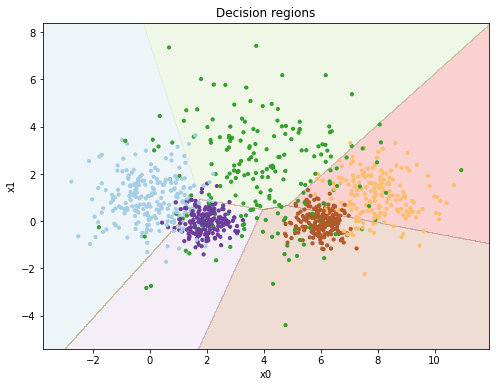

In [577]:
# Class for multi-class classification
# Uses the one vs. rest algorithm where we train one logistic regression classifier for each class
class OvR(NumpyClassifier):
    
    def __init__(self):
        self.classifiers = []
        self.acc = []
        self.loss = []
        self.acc_val = []
        self.loss_val = []
        
    def multi_class_fit(self, X_train, t_multi_train, tol=0.000001, eta=0.01, epoch=10000, n_epochs_no_update=10, X_val=X_val, t_multi_val=t_multi_val):
        # 5 classes 
        for i in range(5):
            # Get class i per iteration for training
            t_train_i = (t_multi_train == i).astype('int')
            t_multi_val_i = (t_multi_val == i).astype('int')
            # Creating classifier and train it
            cl = NumpyLogReg()
            cl.fit(X_train, t_train_i, tol, eta, epoch, n_epochs_no_update, X_val, t_multi_val_i)
            self.classifiers.append(cl)
            self.acc.append(cl.acc_per_epoch[-1])
            self.acc_val.append(cl.acc_per_epoch[-1])
            self.loss.append(cl.loss_per_epoch[-1])
            self.loss_val.append(cl.loss_per_epoch_val[-1])
        
        print(f'\n----Multi-class classification----')
        print("Mean accuracy training = {}".format(np.mean(self.acc)))
        print("Mean accuracy validation = {}".format(np.mean(self.acc_val)))
        print("Mean loss training = {}".format(np.mean(self.loss)))
        print("Mean loss validation = {}".format(np.mean(self.loss_val)))
    
    # Returns a predicted class labels for the classifier with the best probability
    def predict(self, X):
        '''
        Chapter 8.4.1 Marshland
        '''
        X = add_bias_log(X)
        predictions = []
        # Iterates over list of trained logistic classifiers
        for cl in self.classifiers:
            pred = cl.predict_probability(X)
            predictions.append(pred)
        
        # Convert the list of predicted probabilities to a numpy array and transpose it
        # This makes it easier to find the class with the highest probability for each example
        predictions_np = np.array(predictions).T
        # Find the index of the column with the highest probability for each example
        # This corresponds to the predicted class label for each example
        best_class = np.argmax(predictions_np, axis=1)
        return best_class
    
cl_multi = OvR()
cl_multi.multi_class_fit( X_train, t_multi_train, tol=0.000001, eta=0.01, epoch=10000, n_epochs_no_update=10, X_val=X_val, t_multi_val=t_multi_val)
plot_decision_regions(X_train, t_multi_train, cl_multi)

### For in4050-students: Multi-nominal logistic regression
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. 

Remember that this classifier uses softmax in the forward phase. For loss, it uses categorical cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [578]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""

    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        self.loss = []
        self.acc = []
        self.loss_val = []
        self.acc_val = []
        self.epochs_count = 0
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, tol, eta=0.001, epochs=100, X_val=None, t_val=None, n_epochs_no_update=5):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        """
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        best_loss = float('inf') # Value for comparing loss
        epochs_no_update = 0 # Value for checking how many epochs with no improvement
        
        # Itilaize the weights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        if X_val is not None:
            X_val_bias = add_bias(X_val, self.bias)
        
        for e in range(epochs):
            # Calculating loss and accuracy for validation set 
            if X_val is not None and t_val is not None:
                cel_val = self.cross_entropy_loss(X_val_bias, t_val)
                acc_val = accuracy(self.predict(X_val), t_val)
                self.acc_val.append(acc_val)
                self.loss_val.append(cel_val)
            # Calculating loss and accuracy for training set    
            cel = self.cross_entropy_loss(X_train_bias, t_train)
            self.loss.append(cel)
            acc = accuracy(self.predict(X_train), t_train)
            self.acc.append(acc)
                    
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                self.activ_diff(hidden_outs[:, 1:]))  
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights
            
            # Checking if loss has improved with more than "tol"
            if abs(best_loss - cel) >= tol:
                best_loss = cel
                epochs_no_update = 0
            # If there is no improvement we track this with the counter
            else:
                epochs_no_update += 1
            # Stopping training if the loss has not improved with more than "tol" after running "n_epochs_no_update"
            if epochs_no_update >= n_epochs_no_update:
                print("No improvments in loss in {} epochs after {} total epochs. Stopping training.".format(n_epochs_no_update, e))
                break
            self.epochs_count += 1 # Total epochs ran after fitting 
            
        print("Loss after 1 epoch = {}".format(self.loss[0]))
        print("Loss after {} epochs = {}".format(self.epochs_count, self.loss[-1]))
            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the members of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)
    
     # Returns a probability for a value belonging to the positive class
    def predict_probability(self, X):
        forw = self.forward(X)[1]
        score= forw[:, 0]
        return self.activ(score)
    
    # Returns a loss value based on the predicted probability for the training set and target value (Y)
    def cross_entropy_loss(self, X, Y):
        '''
        Page 73, Programming machine learning: from coding to deep learning
        Perrotta, Paolo (2020)
        '''
        y_hat = self.predict_probability(X)
        first_term = Y * np.log(y_hat)
        second_term = (1 - Y) * np.log(1 - y_hat)
        return -np.average(first_term + second_term)
    
    def plot_loss_acc(self):
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
        ax1.plot(self.loss, label="Training Loss")
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(self.acc, color='red', label="Accuracy training")
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        # Checking if validation set is included in the fit-method -> this is the case if list of loss and accuracy for validation is not empty 
        if self.loss_val and self.acc_val:
            ax1.plot(self.loss_val, label="Validation loss")
            ax1.legend()
            ax2.plot(self.acc_val, label="Accuracy validation") 
            ax2.legend()
        plt.show()
                    

No improvments in loss in 5 epochs after 7824 total epochs. Stopping training.
Loss after 1 epoch = 0.6879121484312984
Loss after 7824 epochs = 0.6405414427062682


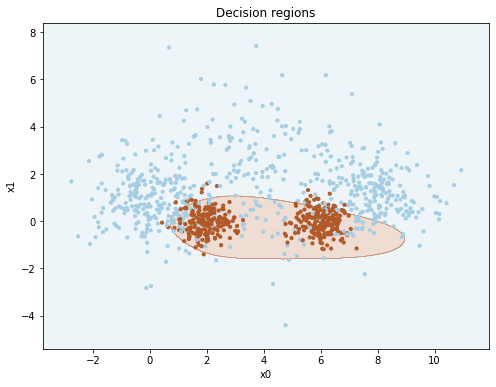

Accuracy training = 0.872
Accuracy validation = 0.864
____________________



In [579]:
mlpb_cl = MLPBinaryLinRegClass(dim_hidden=15)
mlpb_cl.fit(X_train, t2_train, tol=0.00001, eta=0.0001, epochs = 10000, X_val=X_val, t_val=t2_val)
plot_decision_regions(X_train, t2_train, mlpb_cl)
accur = accuracy(mlpb_cl.predict(X_train), t2_train)
accur_val = accuracy(mlpb_cl.predict(X_val), t2_val)
print("Accuracy training = {}".format(accur))
print("Accuracy validation = {}".format(accur_val))
print(f'____________________\n')

**Answer:** As with the previous classifiers, I experienced better results when tuning the eta with a low value and an epochs with a higher value. 

I found consistencly good results with eta=0.0001 and epochs=10000. With the training set, this gave an accuracy around 0.86. Compared to the linear and logical regression classifiers, this result is highly better. Also, when running the algorithm several times I got solutions that were different from eachother. The accuracy didn't vary much, but the decision boundaries was distinct after each run. When running the algorithm several times with the previous classifiers, the results where pretty much identical.  

In addition I experienced overflow when trying to assign values < 0.001 for the eta hyperparameter. 

## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

In [580]:
# Task g
mlpb_cl2 = MLPBinaryLinRegClass(dim_hidden=15)
total_acc = []
total_acc_val = []
print(f'\n---10 runs of training---')
for i in range(10):
    mlpb_cl2.fit(X_train, t2_train, tol=0.00001,eta=0.0001, epochs=10000, X_val=X_val, t_val=t2_val)
    mlpb_cl2.epochs_count = 0 # Resetting epoch counter 
    accur = mlpb_cl2.acc[-1] # We only add the last accuracy (last epoch) per training
    accur_val = mlpb_cl2.acc_val[-1]
    total_acc.append(accur)
    total_acc_val.append(accur_val)

stand_dev = np.std(total_acc)
mean_acc = np.mean(total_acc)
stand_dev_val = np.std(total_acc_val)
mean_acc_val = np.mean(total_acc_val)

print(f'\n---Standard deviation and mean after 10 runs---')
print("Standard deviation accuracy training set: {}".format(stand_dev))
print("Mean accuracy training set: {}".format(mean_acc))
print("Standard deviation accuracy validation set: {}".format(stand_dev_val))
print("Mean accuracy validation set: {}".format(mean_acc_val))


---10 runs of training---
No improvments in loss in 5 epochs after 7457 total epochs. Stopping training.
Loss after 1 epoch = 0.680828956204547
Loss after 7457 epochs = 0.6393729574110592
No improvments in loss in 5 epochs after 5758 total epochs. Stopping training.
Loss after 1 epoch = 0.680828956204547
Loss after 5758 epochs = 0.6381083110942533
No improvments in loss in 5 epochs after 5898 total epochs. Stopping training.
Loss after 1 epoch = 0.680828956204547
Loss after 5898 epochs = 0.6447742710063395
No improvments in loss in 5 epochs after 7969 total epochs. Stopping training.
Loss after 1 epoch = 0.680828956204547
Loss after 7969 epochs = 0.6393695304419247
No improvments in loss in 5 epochs after 6176 total epochs. Stopping training.
Loss after 1 epoch = 0.680828956204547
Loss after 6176 epochs = 0.6387727207367959
No improvments in loss in 5 epochs after 5970 total epochs. Stopping training.
Loss after 1 epoch = 0.680828956204547
Loss after 5970 epochs = 0.6406511419303609
N

**Answer:** When tuning the dim_hidden up, I experienced consistently better accuracy up to `dim_hidden=15`. The graph showing accuracy is similar to the previous classifiers - a fluctuating graph, but slowly moving upwards. On the other hand, the loss function is different from earlier. The graph is showing a big spike in the beggining of training, but is later flattening out. 

I've chosen not to scale the data, because I didn't see any clear differences in the performance after scaling in the linear regression classifier. 

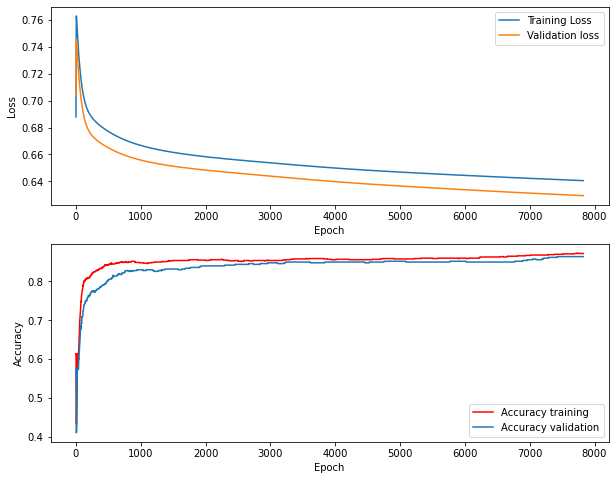

In [581]:
mlpb_cl.plot_loss_acc()

## For IN4050-students: Multi-class neural network

The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. (This is the most fun part of the set :) )

The goal is to use a feed-forward network for non-linear multi-class classfication and apply it to set (X, t_multi).

Modify the netork to become a multi-class classifier. As a check of your implementation, you may apply it to (X, t_2) and see whether you get similar results as above.

Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Plot the decision boundaries for your best classifier..

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.

## For IN4050-students: Multi-class task (X, t_multi)
The following part is only mandatory for in4050-students. In3050-students are also welcome to do it. It requires the earlier IN4050-only tasks. 

Compare the three multi-class classfiers, the one-vs-rest and the multinomial logistic regression from part one, and the multi-class neural network from part two. Evaluate on test, validation and training set as above. 

Comment on what you see

**Answer:** The accuracy value for each data set improves when going from linear regression to logical regression to multi-layer neural network. This was as expected when previously keeping track of accuracy during training with the different classifiers. 

In this case, the table shows that the test data generally gave better results than the validation set. The reason behind this may be because of the model overfitting to the training data and this may result in poor generalization to new, unseen data. 

In [582]:
# Part III: Final testing - Binary task
import pandas as pd
from IPython.display import display

lin_cl = NumpyLinRegClass()
log_cl = NumpyLogReg()
multi_net_cl = MLPBinaryLinRegClass(dim_hidden=15)

# Training the different classifiers 
lin_cl.fit(X_train, t2_train, eta = 0.01, epochs=1200)
log_cl.fit(X_train, t2_train, tol=0.000001, eta=0.01, epochs=10000, n_epochs_no_update=10)
multi_net_cl.fit(X_train, t2_train, tol=0.00001, eta=0.0001, epochs = 10000, X_val=X_val)

# Training set 
acc_lin1 = accuracy(lin_cl.predict(X_train), t2_train)
acc_log1 = accuracy(log_cl.predict(X_train), t2_train)
acc_multi_net1 = accuracy(multi_net_cl.predict(X_train), t2_train)
print("")
print("acc_lin1 = {}".format(acc_lin1))
print("acc_log1 = {}".format(acc_log1))
print("acc_multi_net1 = {}".format(acc_multi_net1))

# Validation set
acc_lin2 = accuracy(lin_cl.predict(X_val), t2_val)
acc_log2 = accuracy(log_cl.predict(X_val), t2_val)
acc_multi_net2 = accuracy(multi_net_cl.predict(X_val), t2_val)
print("")
print("acc_lin2 = {}".format(acc_lin2))
print("acc_log2 = {}".format(acc_log2))
print("acc_multi_net2 = {}".format(acc_multi_net2))

# Test set
acc_lin3 = accuracy(lin_cl.predict(X_test), t2_test)
acc_log3 = accuracy(log_cl.predict(X_test), t2_test)
acc_multi_net3 = accuracy(multi_net_cl.predict(X_test), t2_test)
print("")
print("acc_lin3 = {}".format(acc_lin3))
print("acc_log3 = {}".format(acc_log3))
print("acc_multi_net3 = {}".format(acc_multi_net3))

# 3x3 table for result

df = pd.DataFrame([[acc_lin1, acc_log1, acc_multi_net1], [acc_lin2, acc_log2, acc_multi_net2], [acc_lin3, acc_log3, acc_multi_net3]],
                  index=pd.Index(['Training set', 'Validation set', 'Test set'], name='Data set:'), 
                  columns=['Linear reg','Logistic reg','Multi-layer network'])
display(df)


Loss after 1 epoch: 0.386
Loss after 1200 epochs: 0.18089702770049873
Acc after 1 epoch: 0.614
Acc after 1200 epochs: 0.753

No improvments in loss in 10 epochs after 3954 total epochs. Stopping training.

Loss after 1 epoch = 0.6931471805599454
Loss after 3954 epochs = 0.49951379154918607
Accuracy after 1 epoch = 0.614
Accuracy after 3954 epoch = 0.76
No improvments in loss in 5 epochs after 7111 total epochs. Stopping training.
Loss after 1 epoch = 0.6841422936989873
Loss after 7111 epochs = 0.640144715233241

acc_lin1 = 0.753
acc_log1 = 0.76
acc_multi_net1 = 0.879

acc_lin2 = 0.696
acc_log2 = 0.708
acc_multi_net2 = 0.88

acc_lin3 = 0.722
acc_log3 = 0.728
acc_multi_net3 = 0.88


,Linear reg,Logistic reg,Multi-layer network
Data set:,,,
Training set,0.753,0.760,0.879
Validation set,0.696,0.708,0.880
Test set,0.722,0.728,0.880


In [583]:
# Precision and recall for class 1

# Returns precision and recall for class 1 for a classification object 
def precision_recall(X, t, cl):
    
    y = cl.predict(X)
    # True positive - prediction is 1 and target value is for positive class
    TP = ((y == 1) & (t > 0.5)).sum()
    # False positive - prediction is 0 and target value is for positive class
    FP = ((y == 0) & (t > 0.5)).sum()
    # False negative - prediction is 1 and target value is for negative class
    FN = ((y == 1) & (t < 0.5)).sum()
    # True negative - prediction is 0 and target value is for negative class
    TN = ((y == 0) & (t < 0.5)).sum()
    
    # Precision and recall formula for class 1 (positive class)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    return precision, recall


# Training set 
precision_lin, recall_lin = precision_recall(X_train, t2_train, lin_cl)
precision_log, recall_log = precision_recall(X_train, t2_train, log_cl)
precision_multi, recall_multi = precision_recall(X_train, t2_train, multi_net_cl)
df2 = pd.DataFrame([[precision_lin, precision_log, precision_multi], [recall_lin, recall_log, recall_multi]],
                  index=pd.Index(['Precision', 'Recall']), 
                  columns=['Linear reg','Logistic reg','Multi-layer network'])
df2.name = "Training set (class 1)"
print(df2.name)
display(df2)


# Validation set 
precision_lin, recall_lin = precision_recall(X_val, t2_val, lin_cl)
precision_log, recall_log = precision_recall(X_val, t2_val, log_cl)
precision_multi, recall_multi = precision_recall(X_val, t2_val, multi_net_cl)
df3 = pd.DataFrame([[precision_lin, precision_log, precision_multi], [recall_lin, recall_log, recall_multi]],
                  index=pd.Index(['Precision', 'Recall']), 
                  columns=['Linear reg','Logistic reg','Multi-layer network'])
df3.name = "Validation set (class 1)"
print(df3.name)
display(df3)

# Test set 
precision_lin, recall_lin = precision_recall(X_test, t2_test, lin_cl)
precision_log, recall_log = precision_recall(X_test, t2_test, log_cl)
precision_multi, recall_multi = precision_recall(X_test, t2_test, multi_net_cl)
df4 = pd.DataFrame([[precision_lin, precision_log, precision_multi], [recall_lin, recall_log, recall_multi]],
                  index=pd.Index(['Precision', 'Recall']), 
                  columns=['Linear reg','Logistic reg','Multi-layer network'])
df4.name = "Validation set (class 1)"
print(df4.name)
display(df4)


Training set (class 1)


,Linear reg,Logistic reg,Multi-layer network
Precision,0.642487,0.673575,0.932642
Recall,0.694678,0.695187,0.791209


Validation set (class 1)


,Linear reg,Logistic reg,Multi-layer network
Precision,0.547170,0.575472,0.905660
Recall,0.674419,0.685393,0.827586


Validation set (class 1)


,Linear reg,Logistic reg,Multi-layer network
Precision,0.584158,0.603960,0.876238
Recall,0.682081,0.685393,0.834906
